In [1]:
## Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/X_ray_photos/

/content/drive/My Drive/X_ray_photos


In [3]:
!ls

covid19  foo2.png  foo.png  model.png  normal  test  train  validation


### Importing libraries

In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
base_dir = !pwd
base_dir = base_dir[0]
print(base_dir)
print(type(base_dir))

/content/drive/My Drive/X_ray_photos
<class 'str'>


In [ ]:
# classes = ['covid19', 'normal']

In [ ]:
# # The code below creates a train and a val folder each containing 2 folders (one for each type of X_ray image).
# # It then copies the images from the original folders to these new folders such that 75% of the images go
# # to the training set and 25% of the images go into the validation set.

# for i in classes:

#   os.makedirs(base_dir +'/train/' + i)
#   os.makedirs(base_dir +'/validation/' + i)
#   source = base_dir + '/' + i
#   allFileNames = os.listdir(source)
#   np.random.shuffle(allFileNames)
#   test_ratio = 0.25

#   train_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                       [int(len(allFileNames)* (1 - test_ratio))])

#   train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
#   test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

#   for name in train_FileNames:
#     shutil.copy(name, base_dir +'/train/' + i)

#   for name in test_FileNames:
#     shutil.copy(name, base_dir +'/validation/' + i)

In [ ]:
!ls

covid19  foo.png  model.png  normal  test  train  validation


In [6]:
# Setting paths for training an validation sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
print(train_dir)
print(val_dir)
print(test_dir)
print(type(train_dir))

/content/drive/My Drive/X_ray_photos/train
/content/drive/My Drive/X_ray_photos/validation
/content/drive/My Drive/X_ray_photos/test
<class 'str'>


In [8]:
BATCH_SIZE = 15  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  # Our training data consists of images with width of 180 pixels and height of 180 pixels

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
      img = img.reshape((224,224))
      ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()

In [10]:
# Read images from the disk.
# Decode contents of these images and convert it into proper grid format as per their RGB content.
# Convert them into floating point tensors.
# Rescale the tensors from values between 0 and 255 to values between 0 and 1, 
# as neural networks prefer to deal with small input values.
image_gen_train = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                color_mode='grayscale',
                                                class_mode='binary' 
                                                )

Found 194 images belonging to 2 classes.


In [ ]:
type(train_data_gen)
print(len(train_data_gen))

10


In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
# plotImages(augmented_images)

In [11]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 color_mode='grayscale',
                                                 class_mode='binary')

test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=test_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 color_mode='grayscale',
                                                 class_mode='binary')

Found 66 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [ ]:
len(val_data_gen)

4

In [12]:
sample_training_images, _ = next(train_data_gen) 

# next function returns a batch from the dataset. One batch is a tuple of (many images, many labels).
# For right now, we're discarding the labels because we just want to look at the images.

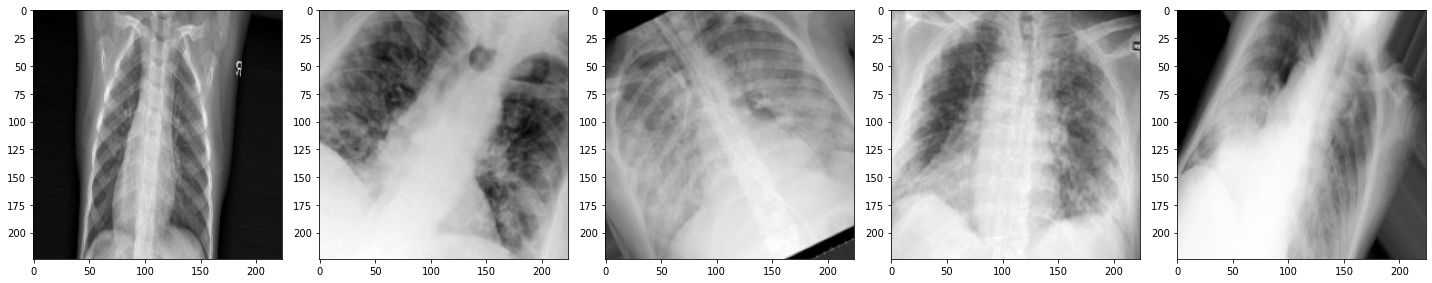

In [13]:
plotImages(sample_training_images[:5])  # Plot images 0-4

### Creating model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
import math

In [38]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 1), use_bias=False))
cnn.add(BatchNormalization(scale=False, center=True))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 1), use_bias=False))
cnn.add(BatchNormalization(scale=False, center=True))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 1), use_bias=False))
cnn.add(BatchNormalization(scale=False, center=True))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(units = 128, use_bias=False))
cnn.add(BatchNormalization(scale=False, center=True))
cnn.add(Activation('relu'))

cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dropout(0.5))

cnn.add(Dense(activation = 'sigmoid', units = 1))

In [39]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 52, 52, 32)        9216      
                                                                 
 batch_normalization_5 (Batc  (None, 52, 52, 32)      

In [40]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
# plot_learning_rate(lr_decay, EPOCHS)

In [42]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.666),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
EPOCHS = 25
history = cnn.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[lr_decay_callback]
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  



Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25
13/13 [==============================] - 6s 364ms/step - loss: 0.4915 - accuracy: 0.7784 - val_loss: 43.8554 - val_accuracy: 0.5000 - lr: 0.0100

Epoch 00002: LearningRateScheduler setting learning rate to 0.006.
Epoch 2/25
13/13 [==============================] - 4s 338ms/step - loss: 0.2880 - accuracy: 0.8711 - val_loss: 28.0572 - val_accuracy: 0.5000 - lr: 0.0060

Epoch 00003: LearningRateScheduler setting learning rate to 0.0036.
Epoch 3/25
13/13 [==============================] - 4s 344ms/step - loss: 0.1898 - accuracy: 0.9485 - val_loss: 24.7326 - val_accuracy: 0.5000 - lr: 0.0036

Epoch 00004: LearningRateScheduler setting learning rate to 0.0021599999999999996.
Epoch 4/25
13/13 [==============================] - 4s 337ms/step - loss: 0.1693 - accuracy: 0.9536 - val_loss: 20.4538 - val_accuracy: 0.5000 - lr: 0.0022

Epoch 00005: LearningRateScheduler setting learning rate to 0.001296.
Epoch 5/25
13/13 

### Visualizing CNN model

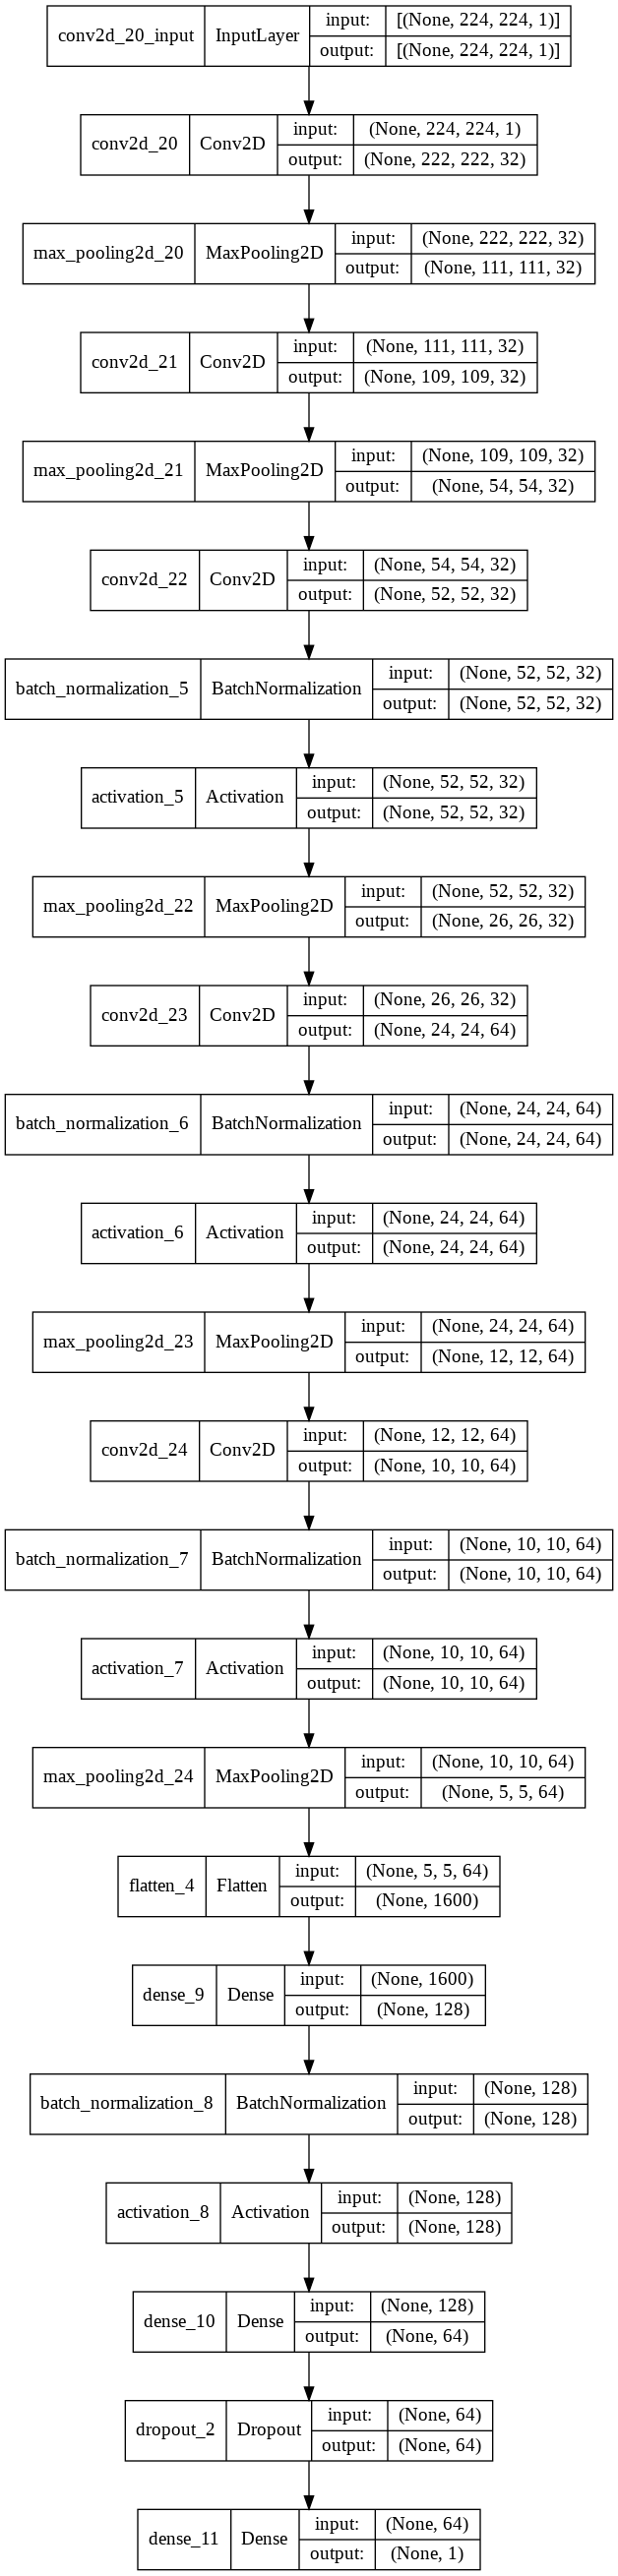

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### Prediction and Results

In [45]:
test_accu = cnn.evaluate(test_data_gen)
print('The testing accuracy is :',test_accu[1]*100, '%')

3/3 [==============================] - 1s 235ms/step - loss: 0.0979 - accuracy: 0.9688
The testing accuracy is : 96.875 %


In [46]:
preds = cnn.predict(test_data_gen,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

3/3 [==============================] - 1s 225ms/step


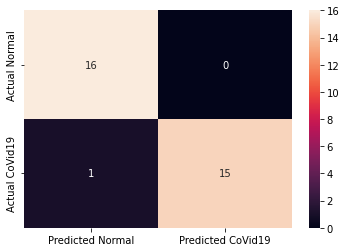

In [47]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_data_gen.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual CoVid19"],
columns=["Predicted Normal", "Predicted CoVid19"])

import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [48]:
print(classification_report(y_true=test_data_gen.classes,y_pred=predictions,target_names =['NORMAL','CoVid19']))

              precision    recall  f1-score   support

      NORMAL       0.94      1.00      0.97        16
     CoVid19       1.00      0.94      0.97        16

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



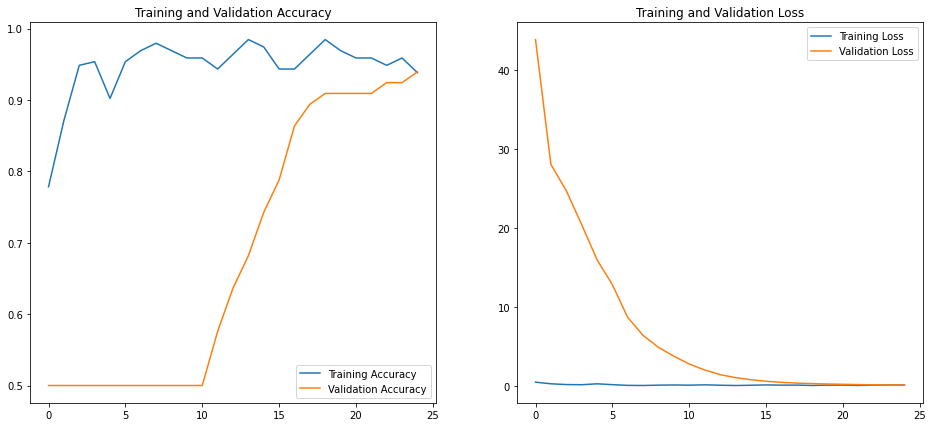

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo4.png')
plt.show()